In [1]:
import random
from gensim.models import FastText
from torch import nn
import torch
from torch.nn import functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pytorch_warmup as warmup

from IPython.display import clear_output
from matplotlib.ticker import MaxNLocator

In [2]:
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)

In [3]:
def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


# Load and preprocess data

In [4]:
data = pd.read_csv('ner.csv')

In [5]:
data

,text,labels
0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...
...,...,...
47954,Opposition leader Mir Hossein Mousavi has said...,O O O B-per I-per O O O O O O O O O O O O O O ...
47955,"On Thursday , Iranian state media published a ...",O B-tim O B-gpe O O O O O O O O B-org I-org O ...
47956,"Following Iran 's disputed June 12 elections ,...",O B-geo O O B-tim I-tim O O O O O O O O O O O ...
47957,"Since then , authorities have held public tria...",O O O O O O O O O O O O O O O O O O O O O


In [6]:
def preproc_df(df):
  new_df = df.copy()
  new_df['labels'] = df['labels'].apply(lambda x: x.split())
  labels = np.concatenate(new_df['labels'].to_numpy())
  unique_labels = np.unique(labels)
  unique_labels = {label: i for i, label in enumerate(unique_labels)}
  new_df['labels'] = new_df['labels'].apply(lambda x: np.vectorize(unique_labels.get)(x))
  new_df['text'] = new_df['text'].apply(lambda x: x.split())
  return new_df, unique_labels

In [7]:
new_data, labels = preproc_df(data)

In [8]:
# Not all examples have the same text and label sizes
lengths_labels = np.vectorize(len)(new_data['labels'])
lengths_text = np.vectorize(len)(new_data['text'])
raws_to_drop = np.where(lengths_labels != lengths_text)[0]
new_data = new_data.drop(raws_to_drop)

print("Number of rows thrown out: ", len(raws_to_drop))

Number of rows thrown out:  13


In [9]:
train_data, test_data = train_test_split(new_data, test_size=0.1)

train_data = train_data.reset_index().drop(['index'], axis=1)
test_data = test_data.reset_index().drop(['index'], axis=1)

In [10]:
lengths_labels_train = np.vectorize(len)(new_data['labels'])

(array([4.4110e+03, 1.9670e+04, 1.8512e+04, 4.8480e+03, 4.3200e+02,
        5.9000e+01, 1.2000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,  11.3,  21.6,  31.9,  42.2,  52.5,  62.8,  73.1,  83.4,
         93.7, 104. ]),
 <BarContainer object of 10 artists>)

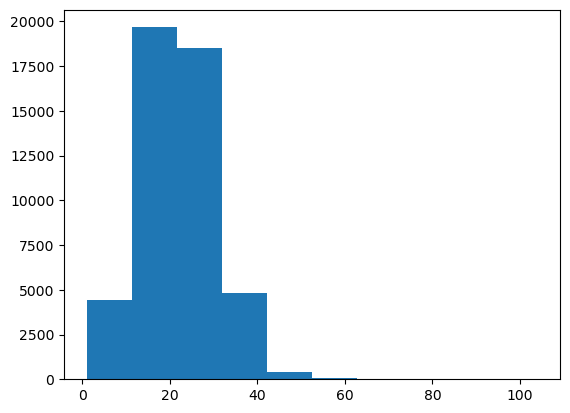

In [11]:
"""
According to the histogram, most examples have text lengths between 10 and 40 tokens.
This means that in most cases the instances in a batch will have approximately the same length.
If it had a large variation in length (for example, 10 and 100), then many paddings would
have to be added to the instances in the package, and this would lead to an increase in training time.
"""

plt.hist(lengths_labels_train)

In [12]:
def count_labels(data):

  all_labels = np.concatenate(data['labels'].to_numpy())
  unique_labels = np.unique(all_labels, return_counts=True)

  return {label: count for label, count in zip(unique_labels[0], unique_labels[1])}

In [13]:
train_labels_count = count_labels(train_data)

In [14]:
labels, train_labels_count

({'B-art': 0,
  'B-eve': 1,
  'B-geo': 2,
  'B-gpe': 3,
  'B-nat': 4,
  'B-org': 5,
  'B-per': 6,
  'B-tim': 7,
  'I-art': 8,
  'I-eve': 9,
  'I-geo': 10,
  'I-gpe': 11,
  'I-nat': 12,
  'I-org': 13,
  'I-per': 14,
  'I-tim': 15,
  'O': 16},
 {0: 372,
  1: 274,
  2: 33847,
  3: 14295,
  4: 181,
  5: 18125,
  6: 15284,
  7: 18264,
  8: 272,
  9: 222,
  10: 6655,
  11: 185,
  12: 46,
  13: 15079,
  14: 15548,
  15: 5839,
  16: 798465})

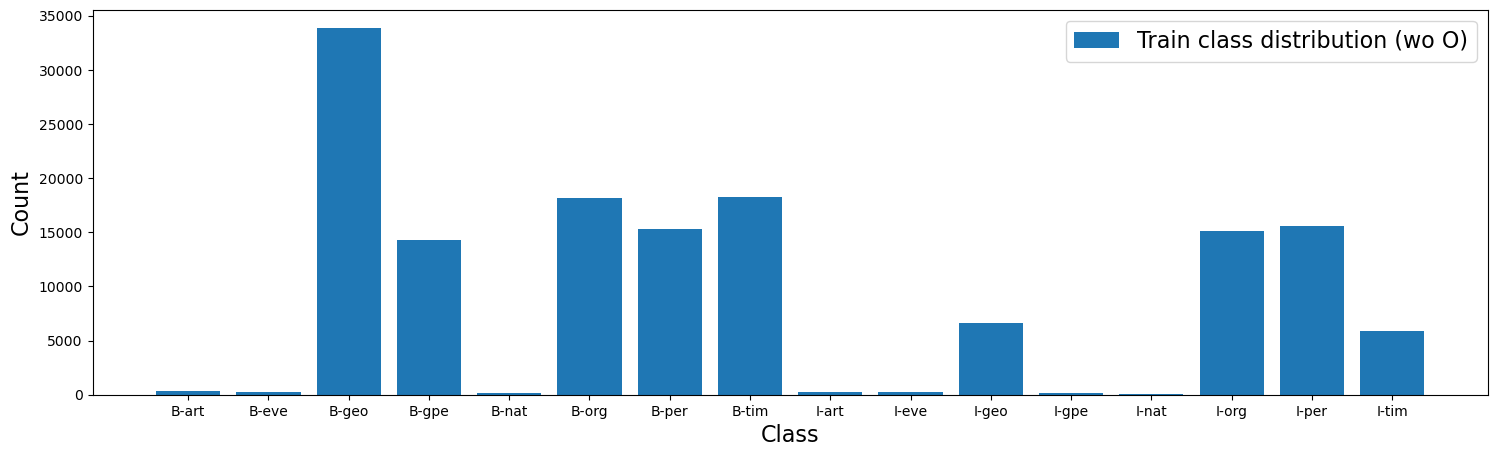

In [15]:
"""
We observe a class imbalance
"""

plt.subplots(figsize=(18,5))
plt.bar(list(labels.keys())[:-1], list(train_labels_count.values())[:-1])
plt.legend(["Train class distribution (wo O)"], fontsize = 16)
plt.xlabel("Class", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.show()

# Word embeddings

In [16]:
ft_model = FastText.load_fasttext_format('wiki.simple.bin')
fasttext_wv = ft_model.wv

C:\Users\iva52\AppData\Local\Temp\ipykernel_4832\3862662545.py:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  ft_model = FastText.load_fasttext_format('wiki.simple.bin')


In [17]:
def add_embeddings(df, word_emb_model):
  new_df = df.copy()
  word_embs = np.frompyfunc(lambda x: word_emb_model[x],1, 1)(df['text'])
  new_df['embeddings'] = word_embs
  return new_df

In [18]:
word_embs_size = fasttext_wv.vector_size

In [19]:
train_data = add_embeddings(train_data, fasttext_wv)
test_data = add_embeddings(test_data, fasttext_wv)

# Create Dataset

In [20]:
class NERDataset(Dataset):
  def __init__(self, df):
    super().__init__()
    self.df = df

  def __getitem__(self, index):

    embs = self.df['embeddings'][index]
    labels = self.df['labels'][index]

    embs = torch.tensor(embs)
    labels = torch.tensor(labels)

    return embs, labels

  def __len__(self):
    return len(self.df)

In [21]:
train_dataset = NERDataset(train_data)
test_dataset = NERDataset(test_data)

In [22]:
pad_class = max(labels.values()) + 1
num_classes = len(labels) + 1

In [23]:
def collate_fn(batch):
  embs = [pair[0] for pair in batch]
  target = [pair[1] for pair in batch]
  all_lengths = np.vectorize(len)(np.array(target, dtype = object))
  max_length = all_lengths.max()
  pad_lengths = max_length - all_lengths

  pad_embs = torch.zeros(embs[0].shape[-1])
  embs = [torch.cat((exmp, pad_embs.repeat(pad_lengths[i], 1))) for i, exmp in enumerate(embs)]
  embs = torch.stack(embs)

  pad_target = torch.tensor(pad_class)
  target = [torch.cat((exmp, pad_target.repeat(pad_lengths[i]))) for i, exmp in enumerate(target)]
  target = torch.stack(target)

  return embs.to(device), target.to(device)

In [24]:
batch_size = 8

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn = collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)

# Loss and metrics

In [25]:
def compute_class_weight(y):
  return len(y) / (len(np.unique(y)) * np.bincount(y))

In [26]:
def CE_batch(pred, target, weight = None, ignore_index = -100):
  batch_size = target.shape[0]
  one_hot_target = F.one_hot(target, num_classes=pred.shape[-1])

  softmax = torch.exp(pred)
  softmax = softmax / torch.sum(softmax, dim = -1).unsqueeze(-1)
  loss = -torch.log(softmax) * one_hot_target

  if weight is not None:
    loss *= weight
  loss = loss.sum(-1)

  drop_loss = (target == ignore_index)
  seq_lengths = torch.logical_not(drop_loss).sum(dim = -1)
  loss[drop_loss] = 0

  if weight is not None:
    sum_weights = weight[target]
    sum_weights[target == ignore_index] = 0
    loss = loss.sum(dim = -1) / sum_weights.sum(-1)
  else:
    loss = loss.sum(dim = -1) /  seq_lengths

  return loss.sum()/batch_size

In [27]:
def delete_paddings_and_flatten(pred, target, pad):
  mask = (target != pad)
  new_target = torch.masked_select(target, mask)
  new_pred = torch.masked_select(pred, mask)

  return new_pred, new_target

In [28]:
def f1_score_macro(pred, target):
  classes = torch.unique(torch.cat((pred, target)))

  pred_mask = (pred == classes.unsqueeze(1))
  target_mask = (target == classes.unsqueeze(1))

  tp = torch.logical_and(pred_mask, target_mask).sum(dim=-1)
  tp_plus_fp = pred_mask.sum(dim=-1)
  tp_plus_fn = target_mask.sum(dim=-1)
  precision = tp / tp_plus_fp
  recall = tp / tp_plus_fn
  f1_score = torch.nan_to_num(2 * precision * recall / (precision + recall))

  return f1_score.sum()/len(classes)

# LSTM

In [29]:
class LSTMblock(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    
    self.hidden_size = hidden_size
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()

    self.linear_ih = nn.Linear(input_size, 4 * hidden_size)
    self.linear_hh = nn.Linear(hidden_size, 4 * hidden_size)

  def forward(self, input, ht_minus_1, ct_minus_1):
    
    states_ih = self.linear_ih(input)
    states_hh = self.linear_hh(ht_minus_1)
    
    states = states_ih + states_hh
    
    i, f, g, o = torch.split(states, self.hidden_size, dim=-1)    

    i_state = self.sigmoid(i)
    f_state = self.sigmoid(f)
    g_state = self.tanh(g)
    o_state = self.sigmoid(o)

    ct = ct_minus_1 * i_state + f_state * g_state
    ht = self.tanh(ct) * o_state

    return ht, ct

In [30]:
class BiLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers = 1, batch_first=False):
    super().__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.batch_first = batch_first
    self.num_layers = num_layers

    self.lstm_blocks = nn.ModuleList(
        [LSTMblock(input_size, hidden_size)] +
        [LSTMblock(2*hidden_size, hidden_size) for _ in range(num_layers - 1)] +
        [LSTMblock(input_size, hidden_size)] +
        [LSTMblock(2*hidden_size, hidden_size) for _ in range(num_layers - 1)])

  def forward(self, input, h0=None, c0=None):

    if self.batch_first:
      input = input.transpose(1, 0)

    seq_len, batch_size = input.shape[0:2]
    num_layers = self.num_layers
    hidden_size = self.hidden_size
    device = next(self.parameters()).device
    
    ht_minus_1 = torch.zeros(batch_size, hidden_size, device=device)
    ct_minus_1 = torch.zeros(batch_size, hidden_size, device=device)

    for i in range(num_layers):
      ht_forward = []
      for j in range(seq_len):
        ht, ct = self.lstm_blocks[i](input[j], ht_minus_1, ct_minus_1)

        ht_forward.append(ht)
        ht_minus_1 = ht
        ct_minus_1 = ct

      ht_backward = []
      ht_minus_1.zero_()
      ct_minus_1.zero_()
      
      for j in range(-1, -seq_len-1, -1):
        ht, ct = self.lstm_blocks[i + num_layers](input[j], ht_minus_1, ct_minus_1)

        ht_backward.append(ht)
        ht_minus_1 = ht
        ct_minus_1 = ct
        
      ht_minus_1.zero_()
      ct_minus_1.zero_()

      ht_forward = torch.stack(ht_forward)
      ht_backward = torch.flip(torch.stack(ht_backward), dims=(0,))

      input = torch.cat((ht_forward, ht_backward), dim=-1)

    outputs = input 
    
    if self.batch_first:
      outputs = outputs.transpose(1, 0)

    return outputs

In [31]:
class LSTMNer(nn.Module):
  def __init__(self, lstm, hidden_size, num_classes):
    super().__init__()

    self.lstm = lstm
    self.linear = nn.Linear(hidden_size, num_classes)

  def forward(self, input):

    res = self.lstm(input)
    res = self.linear(res)

    return res

In [32]:
input_size = word_embs_size
hidden_size = 768

lstm = BiLSTM(input_size, hidden_size, num_layers=2, batch_first=True).to(device)
model = LSTMNer(lstm, 2*hidden_size, num_classes).to(device)

# Train and eval

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
class_weights = compute_class_weight(np.concatenate(train_data['labels'].to_numpy()))

# add weight for pad class
class_weights = torch.tensor(np.append(class_weights, 0), device = device)

print("Total trainable params: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Total trainable params:  20769810


In [34]:
def train(model, optimizer, dataloader):
  total_loss = 0
  total_score = 0

  model.train(True)
  for batch in tqdm(dataloader):
    optimizer.zero_grad()

    input = batch[0]
    target = batch[1]

    output = model(input)

    loss = CE_batch(output, target, weight=class_weights)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    pred = torch.argmax(output, dim=-1)
    pred, target = delete_paddings_and_flatten(pred.cpu(), target.cpu(), pad_class)
    total_score += f1_score_macro(pred, target).item()

  return total_loss/len(dataloader), total_score/len(dataloader)

In [35]:
def eval(model, dataloader):
  total_loss = 0
  total_score = 0

  model.eval()
  with torch.no_grad():
    for batch in tqdm(dataloader):
      input = batch[0]
      target = batch[1]
      output = model(input)

      loss = CE_batch(output, target, weight=class_weights)
      total_loss += loss.item()

      pred = torch.argmax(output, dim=-1)
      pred, target = delete_paddings_and_flatten(pred.cpu(), target.cpu(), pad_class)
      total_score += f1_score_macro(pred, target).item()

  return total_loss/len(dataloader), total_score/len(dataloader)

In [36]:
train_loss, train_score = eval(model, train_dataloader)
test_loss, test_score = eval(model, test_dataloader)

loss_history_train = [train_loss]
loss_history_test = [test_loss]
score_history_train = [round(train_score * 100, 2)]
score_history_test = [round(test_score * 100, 2)]

100%|██████████| 600/600 [00:26<00:00, 22.81it/s]


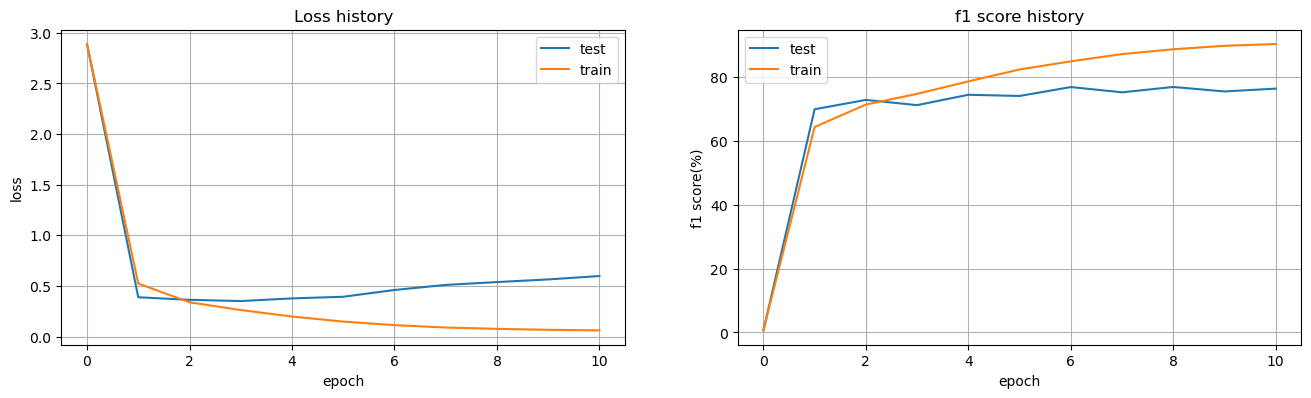

In [37]:
num_epoch = 10

for epoch in range(1, num_epoch + 1):
  train_loss, train_score = train(model, optimizer, train_dataloader)
  test_loss, test_score = eval(model, test_dataloader)

  loss_history_train.append(train_loss)
  loss_history_test.append(test_loss)

  score_history_train.append(round(train_score * 100, 2))
  score_history_test.append(round(test_score * 100, 2))

  clear_output(True)
  plt.figure(figsize=(16, 9))
  plt.subplot(2, 2, 1)
  plt.title("Loss history")
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.plot(list(range(epoch+1)), loss_history_test, label = "test")
  plt.plot(list(range(epoch+1)), loss_history_train, label = "train")
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend()
  plt.grid()

  plt.subplot(2, 2, 2) 
  plt.title("f1 score history")
  plt.ylabel("f1 score(%)")
  plt.xlabel("epoch")
  plt.plot(list(range(epoch+1)), score_history_test, label = "test")
  plt.plot(list(range(epoch+1)), score_history_train, label = "train")
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend()
  plt.grid()

  plt.show()

In [38]:
print(f"Final test f1 score: {round(test_score * 100, 2)}%")

Final test f1 score: 76.42%


# Add CRF layer

In [39]:
class CRF(nn.Module):
  def __init__(self, num_labels):
    super().__init__()
    self.num_labels = num_labels + 2 # num labels + (START, END)
    self.transition_scores = nn.Parameter(torch.empty(self.num_labels, self.num_labels))
    nn.init.xavier_uniform_(self.transition_scores)
    self.se_score = -1000

  def __call__(self, x, y):
    # x - BiLSTM outputs float[batch_size, seq_len, num_labels]
    # y - targets int[batch_size, seq_len]

    num_labels = self.num_labels
    device = y.device

    # Expand x and y with START and END
    x = self.expand_input(x)

    se_labels = torch.tensor([num_labels-1]).repeat(y.shape[0], 1).to(device)
    y = torch.cat((se_labels - 1, y, se_labels), dim=-1)

    # Compute real path scores
    real_es = torch.gather(x, -1, y.unsqueeze(-1)).squeeze(-1).sum(-1) # Emission score [batch_size]
    real_t = torch.stack((y[:, :-1], y[:, 1:]), dim=-1)
    real_ts = self.transition_scores[real_t[:, :, 0], real_t[:, :, 1]].sum(-1) # Transition score [batch_size]
    real_path_scores = real_es + real_ts

    # Compute all paths scores
    x = x.transpose(1, 0) # [seq_len, batch_size, num_labels]
    previous = x[0] 
    seq_len = x.shape[0]
    # loop over seq_len, last previous is all_paths_score
    for i in range(1, seq_len):
      prev =  previous.unsqueeze(-1)
      obs = x[i].unsqueeze(-2)
      scores = prev + obs + self.transition_scores # [batch_size, num_labels, num_labels]
      scores = torch.logsumexp(scores, dim = -2) # [batch_size, num_labels]
      previous = scores

    loss = -real_path_scores + torch.logsumexp(previous, dim=-1)

    return loss.sum()/loss.shape[0]

  def expand_input(self, x):
    num_labels = self.num_labels
    se_score = self.se_score
    device = x.device

    se_scores = torch.tensor([se_score]).repeat(*x.shape[0:2], 1).to(device)
    x = torch.cat((x, se_scores, se_scores), dim=-1)

    start_scores = torch.full((x.shape[0], 1, x.shape[2]), se_score).to(device)
    start_scores[:, :, num_labels - 2] = 0
    end_scores = torch.full((x.shape[0], 1, x.shape[2]), se_score).to(device)
    end_scores[:, :, num_labels - 1] = 0

    x = torch.cat((start_scores, x, end_scores), dim = -2)

    return x
  
  def predict(self, x):
    x = self.expand_input(x)
    x = x.transpose(1, 0) # [seq_len, batch_size, num_labels]
    previous = x[0]

    alpha = []

    seq_len = x.shape[0] # [batch_size, num_labels]
    for i in range(1, seq_len):
      prev =  previous.unsqueeze(-1)
      obs = x[i].unsqueeze(-2)
      scores = prev + obs + self.transition_scores #[batch_size, num_labels, num_labels]

      max_values = torch.max(scores, dim = -2)
      previous = max_values.values
      alpha.append(max_values.indices)
    
    alpha = torch.stack(alpha) #[seq_len - 1, batch_size, num_labels]
    prev_label = previous.max(dim=-1).indices.unsqueeze(-1) #[batch_size, 1]
    labels = prev_label 

    for i in alpha.flip(0):
      prev_label = torch.gather(i, -1, prev_label)
      labels = torch.cat((prev_label, labels), -1)

    return labels[:, 1:-1]

In [40]:
class NerBiLSTMCRF(nn.Module):
  def __init__(self, bilstm, num_classes):
    super().__init__()
    self.bilstm = bilstm
    self.crf_layer = CRF(num_classes)

  def forward(self, input, target):
    emission_scores = self.bilstm(input)
    loss = self.crf_layer(emission_scores, target)
    pred = self.crf_layer.predict(emission_scores)

    return loss, pred

In [41]:
crf_model = NerBiLSTMCRF(model, num_classes).to(device)
optimizer = torch.optim.Adam(crf_model.parameters(), lr = 0.001)

In [42]:
def crf_train(crf_model, optimizer, dataloader):
  total_loss = 0
  total_score = 0

  crf_model.train(True)
  for batch in tqdm(dataloader):
    optimizer.zero_grad()

    input = batch[0]
    target = batch[1]

    loss, pred = crf_model(input, target)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    pred, target = delete_paddings_and_flatten(pred.cpu(), target.cpu(), pad_class)
    total_score += f1_score_macro(pred, target).item()

  return total_loss/len(dataloader), total_score/len(dataloader)

In [43]:
def crf_eval(crf_model, dataloader):
  total_loss = 0
  total_score = 0

  crf_model.eval()
  with torch.no_grad():
    for batch in tqdm(dataloader):
      input = batch[0]
      target = batch[1]
      loss, pred = crf_model(input, target)
      total_loss += loss.item()

      pred, target = delete_paddings_and_flatten(pred.cpu(), target.cpu(), pad_class)
      total_score += f1_score_macro(pred, target).item()

  return total_loss/len(dataloader), total_score/len(dataloader)

In [44]:
train_loss, train_score = crf_eval(crf_model, train_dataloader)
test_loss, test_score = crf_eval(crf_model, test_dataloader)

loss_history_train = [train_loss]
loss_history_test = [test_loss]
score_history_train = [round(train_score * 100, 2)]
score_history_test = [round(test_score * 100, 2)]

100%|██████████| 600/600 [00:41<00:00, 14.63it/s]


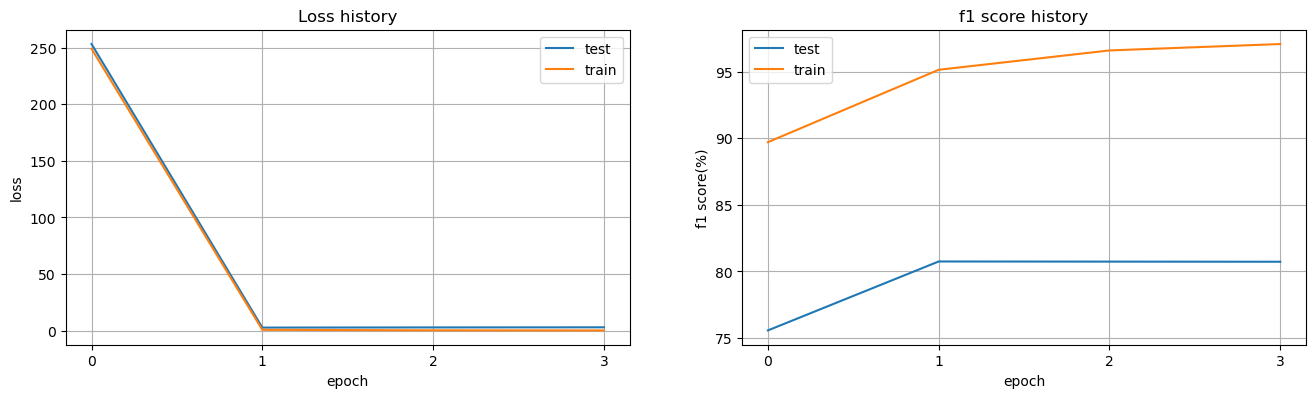

In [45]:
num_epoch = 3

for epoch in range(1, num_epoch + 1):
  train_loss, train_score = crf_train(crf_model, optimizer, train_dataloader)
  test_loss, test_score = crf_eval(crf_model, test_dataloader)

  loss_history_train.append(train_loss)
  loss_history_test.append(test_loss)

  score_history_train.append(round(train_score * 100, 2))
  score_history_test.append(round(test_score * 100, 2))

  clear_output(True)
  plt.figure(figsize=(16, 9))
  plt.subplot(2, 2, 1)
  plt.title("Loss history")
  plt.ylabel("loss")
  plt.xlabel("epoch")
  plt.plot(list(range(epoch+1)), loss_history_test, label = "test")
  plt.plot(list(range(epoch+1)), loss_history_train, label = "train")
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend()
  plt.grid()

  plt.subplot(2, 2, 2)
  plt.title("f1 score history")
  plt.ylabel("f1 score(%)")
  plt.xlabel("epoch")
  plt.plot(list(range(epoch+1)), score_history_test, label = "test")
  plt.plot(list(range(epoch+1)), score_history_train, label = "train")
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend()
  plt.grid()

  plt.show()

In [46]:
print(f"Final test f1 score: {round(test_score * 100, 2)}%")

Final test f1 score: 80.73%


In [47]:
torch.save(crf_model.state_dict(), 'ner_bilstm_crf_weights.pth')

In [48]:
labels_rev = {v: k for k, v in labels.items()}

In [49]:
i = 2876

text = test_data['text'][i]
embs = test_data['embeddings'][i]
target = test_data['labels'][i]
target = torch.tensor(target, device=device).unsqueeze(0)
embs = torch.tensor(embs, device=device).unsqueeze(0)

_, pred = crf_model(embs, target)
score = f1_score_macro(pred.cpu().flatten(), target.cpu().flatten()).item()

target = [labels_rev[i] for i in target[0].tolist()]
pred = [labels_rev[i] for i in pred[0].tolist()]

print(" ".join(text))
print(target)
print(pred)
print(score)

The boat originated from Somalia and most of those on board are believed to have been Somalians .
['O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-per', 'O']
['O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O']
0.5
